In [42]:
#Import libraries
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

In [85]:
#We want to test different optimizers using different optimizer evaluation functions
#Run each optimizer across a) the Rosenbrock function, b) Local Minima filled functions, c) Bowl-Shaped functions, d) Plate-Shaped functions
# and e) Functions with Steep drops

#After running each optimizer across these functions, take the average across all functions and plot to determine average performance
#Generate x data for each test - use same initialization distribution to ensure reproducibility and fairness while testing
import math

#Class to test optimizer
class OptimizerTest():
    #Initialize optimizer testing object
    def __init__(self, Optimizer, epochs, params, **opt_args):
        #Instantiate new Optimizer object - check if optional keyword arguments (specific arguments for the optimizer) have been provided
        if opt_args != {}:
            vals = [args for args in opt_args.values()]
            self.optimizer = Optimizer([params], *vals)
        else: self.optimizer = Optimizer([params])
        #Set the parameters to an initial x and y value, optimize_(var) variables will be modiifed in the optimization process via the optimizeParams() method
        self.params = params
        #Set both the initial and optimized versions of x and y to COPIES of the original parameter such as to not modify the input tensor
        self.initial_x, self.initial_y = torch.clone(params)
        #Set epochs
        self.epochs = epochs

    #Optimize the loss function on a given loss function
    def optimizeParams(self, loss_function):
        #Fit the given 3D function
        #Store losses (z values) obtained via optimizing this function
        losses = []
        points = []
        #Iterate over number of epochs
        for epoch in range(self.epochs):
            #Set all gradients to zero - this is to prevent gradient accumulation as they do not reset per epoch
            self.optimizer.zero_grad()
            #Compute the loss
            x, y = self.params
            loss = loss_function(x, y)
            #Compute the gradients
            loss.backward()
            #Run the optimizer
            self.optimizer.step()
            #Add loss to loss array - use item() for both this append and the next one to extract the raw scalar as opposed to adding the tensor
            #Adding the tensor directly causes unexpected behaviour as the optimizer directly modifies the base; thereby changing all views and raising exceptions
            losses.append(loss.item())
            #Append points to point array for visualization and evaluation
            points.append([x.item(), y.item(), loss.item()])
        #Add losses array to dictionary of all optimization functions
        #To find the name of the function given, use the .__name__ method
        self.all_losses["{}".format(loss_function.__name__)] = losses
        self.all_points["{}".format(loss_function.__name__)] = points
        
    #Method to run tests - create a new LossFunctions object, and run the optimization method on all of those functions
    def runTests(self):
        #Create dictionary of all losses
        self.all_losses = {}
        #Create dictionary of all points
        self.all_points = {}
        #Create new LossFunctions object to obtain various testing functions
        TestFunctions = LossFunctions(self.params)
        #Define list of loss functions we would like to optimize from Lossfunctions
        self.loss_opt_funcs = ["RosenbrockLoss"]#, "BukinLoss", "BohachevskyLoss", "BoothLoss", "CamelLoss", "EasomLoss"]
        #Optimize each given loss function (call optimizeParams for each function in the list)
        for loss_func in self.loss_opt_funcs:
            func = eval('TestFunctions.{}'.format(loss_func))
            self.optimizeParams(func)
        return self.all_losses, self.all_points
    
#Define class of all loss functions being used
#Methods to calculate the losses dependent on the function - given a set of x and y points, these functions will determine the respective z coordinate (which is our loss)
#The optimizers chosen will need to optimize this function and arive at its local minima; as all have two input parameters, they form a three dimensional graph
class LossFunctions():
    #Initialize x and y values from params upon initialization - these are the x and y values that each test will start with (before they are updated)
    def __init__(self, params): self.initial_x, self.initial_y = params

    #Rosenbrock function - one of the most famous functions for evaluating optimization methods
    def RosenbrockLoss(self, x, y):
        term_1 = torch.pow(1.0 - x, 2)
        term_2 = 100 * torch.pow(torch.subtract(y, torch.pow(x, 2)), 2)
        return torch.add(term_1, term_2)

    #Bukin Function (testing for many local minima)
    def BukinLoss(self, x, y):
        #Equation - z = 100sqr(|y-0.01x^2|)+0.01(x+10)
        term_1 = 100 * torch.abs(y - (0.01 * torch.pow(x, 2)))
        return term_1 + (0.01 * torch.abs(x + 10))

    #Bohachevsky Functions (testing to see if optimizer works on bowl-shaped functions)
    def BohachevskyLoss(self, x, y):
        #Equation - z = x^2 + 2y^2 - 0.3cos(3pix) - 0.4cos(4piy) + 0.7
        cosine_term_1 = 0.3 * torch.cos(3 * math.pi * x)
        cosine_term_2 = 0.4 * torch.cos(4 * math.pi * x)
        return torch.pow(x, 2) + (2 * torch.pow(y, 2)) - cosine_term_1 - cosine_term_2 + 0.7
    
    #Booth Function (Plate shaped function)
    def BoothLoss(self, x, y):
        #Equation - z = (x + 2y - 7)^2 + (2x + y -5)^2
        term_1 = torch.pow(x + (2 * y) - 7, 2)
        term_2 = torch.pow(2 * x - 5, 2)
        return term_1 + term_2
    
    #"Six-Hump" Camel function (function with six local minima)
    def CamelLoss(self, x, y):
        #Equation - z = (4 - 2.1x^2 + x^4/3)x^2 + xy + (-4 + 4y^2)y^2
        term_1 = torch.mul(4 - 2.1 * torch.pow(x, 2) + (torch.pow(x, 4)/3), torch.pow(x, 2))
        term_3 = torch.mul((-4 + 4*torch.pow(y, 2)), torch.pow(y, 2))
        return term_1 + torch.mul(x, y) + term_3
    
    #Easom Function (has very steep drops but is otherwise unimodal - the minimum takes a small space relative to the search space of the function)
    def EasomLoss(self, x, y):
        #Equation - z = -cos(x)cos(y)exp(-(x-pi)^2-(y-pi)^2)
        cosine_term = - torch.mul(torch.cos(x), torch.cos(y))
        exponential_term = torch.subtract(-torch.pow(x - math.pi, 2), torch.pow(y - math.pi, 2))
        return torch.mul(cosine_term, torch.exp(exponential_term))

#Function to calculate the loss (Euclidean distance between current point and global minima)
#The loss will be the DISTANCE from the local minima to the gradient - we're measuring how fast the optimizer can reach this minima
def computeEuclideanLoss(current_point, global_minima):
    #Compute the squared difference between the two vectors
    squared_difference = torch.float_power(torch.subtract(current_point, global_minima), 2.0)
    #Add all squared differences, convert the resulting scalar to a float, and then take the square root
    return torch.sqrt(torch.sum(squared_difference))

In [86]:
#Initialize x and y vectors - 3D functions will be written in the form z(x, y)
#Both x and y will be initialized with normal distributions from ranges -5 to 5
from random import uniform
x = uniform(-1, 1)
y = uniform(-1, 1)
#Create tuple and convert to tensor
XY = (x, y)

#Import Custom Adam Optimizer Implementation and all other optimizers
from CustomAdam import CustomAdam
from torch.optim import SGD, Adagrad, RMSprop
#List of all optimizers
optimizers = ["CustomAdam", "SGD", "Adagrad", "RMSprop"]
#Dictionary of all losses
optimizer_losses = {}
#Dictionary of all points traversed during the optimization process
optimizer_points = {}
#List of all objective functions
loss_funcs = ["Rosenbrock", "Bukin", "Bohachevsky", "Booth", "Camel", "Easom"]

#Number of steps to run optimizers
steps = 10
#Iterate over all optimizers
for opt in optimizers:
    #Redefine every iteration as these parameters are optimzied and therefore modified - we want the same set of parameters to be passed into all optimizer tests
    #Redefining the tensor also cuts off all existing gradients
    XY_TENSOR = torch.tensor(XY, requires_grad = True, dtype = torch.float64)
    #Run optimizer tests on given tensor - create a new Optimizer test object and call runTests()
    #If the optimizer is SGD, add the required learning rate parameter (same as the Adam stepsize)
    if opt == "SGD":
        TestInstance = OptimizerTest(Optimizer = eval(opt), epochs = steps, params = torch.tensor(XY, requires_grad = True, dtype = torch.float64), lr = 0.001)
    else: TestInstance = OptimizerTest(Optimizer = eval(opt), epochs = steps, params = torch.tensor(XY, requires_grad = True, dtype = torch.float64))
    optimizer_losses[opt], optimizer_points[opt] = TestInstance.runTests()
#Print all losses and points
print("ALL LOSSES:", optimizer_losses, end = '\n\n')
print("ALL POINTS:", optimizer_points)

ALL LOSSES: {'CustomAdam': {'RosenbrockLoss': [193.23511716107387, 192.40974712706225, 192.06495047836773, 191.7976701225002, 191.54554957459126, 191.29420999041986, 191.04013113024124, 190.78260321964723, 190.52152721782477, 190.25685373193556]}, 'SGD': {'RosenbrockLoss': [193.23511716107387, 11.251902175470152, 5.135972826769581, 2.7047569121453185, 1.6031263883566553, 1.0699048813905152, 0.8016220892125835, 0.663154990432453, 0.5902934927063077, 0.5512553324745864]}, 'Adagrad': {'RosenbrockLoss': [193.23511716107387, 185.08549163717873, 179.5406069180369, 175.13335118788657, 171.39923020585712, 168.12207707883653, 165.18082794694502, 162.4997002073497, 160.0275704747495, 157.72803935421908]}, 'RMSprop': {'RosenbrockLoss': [193.23511716107387, 121.6264375788371, 88.5029215385532, 68.15325605302019, 54.1762668270576, 43.96896414208913, 36.21624215317014, 30.164235415893543, 25.343196181149878, 21.44246836752998]}}

ALL POINTS: {'CustomAdam': {'RosenbrockLoss': [[0.9855215481416469, -0

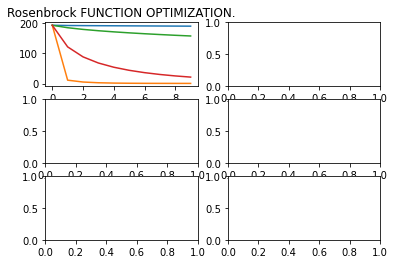

In [93]:
#First, plot losses for each test function and compare to determine optimizer convergence speed

loss_funcs = ["RosenbrockLoss", "BukinLoss", "BohachevskyLoss", "BoothLoss", "CamelLoss", "EasomLoss"]

import matplotlib.pyplot as plt
%matplotlib inline

#Create subplot
loss_plot, [[Rosenbrock_ax, Bukin_ax], [Bohachevsky_ax, Booth_ax], [Camel_ax, Easom_ax]] = plt.subplots(3, 2)
#Function to plot losses for a particular objective function w.r.t all optimizers
def plotLosses(loss_func):
    #Iterate over each optimizer
    for optimizer in optimizers:
        globals()[loss_func + "_ax"].plot(optimizer_losses[optimizer][loss_func + "Loss"])
        globals()[loss_func + "_ax"].set_title(loss_func + " FUNCTION OPTIMIZATION.")

plotLosses("Rosenbrock")

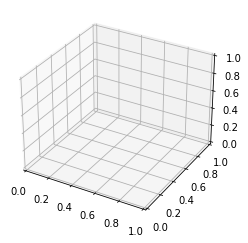

In [69]:
#Create 3D-animation to visualize optimization process
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits import mplot3d
%matplotlib inline

figure = plt.figure()
ax = plt.axes(projection = "3d")